In [1]:
# import libraries
import numpy as np
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Input, Activation, Dropout, Add, LSTM, GRU, RNN, LayerNormalization, BatchNormalization, Conv1D, MaxPooling1D, Flatten
from keras.optimizers import Adam,SGD
import tensorflow as tf
from keras import Model, regularizers, activations
import pickle
from copy import deepcopy

# disable warnings to ignore overflow error
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
# parameters for CSTR
T_0_cstr = 300
V_cstr = 1
k_0_cstr = 8.46*(np.power(10,6))
C_p_cstr = 0.231
rho_L_cstr = 1000
Q_s_cstr = 0.0
F_cstr = 5
E_cstr = 5*(np.power(10,4))
delta_H_cstr = -1.15*(np.power(10,4))
R_cstr = 8.314
C_A0s_cstr = 4

t_final_cstr = 0.005
t_step_cstr = 1e-4

# parameters for Batch
V_batch = 1
k_0_batch = 8.46*(np.power(10,7))
C_p_batch = 0.231
rho_L_batch = 1000
Q_s_batch = 0
E_batch = 5*(np.power(10,4))
delta_H_batch = -1.15*(np.power(10,4))
R_batch = 8.314

t_final_batch = 0.05
t_step_batch = 1e-4

# parameters for neural networks
num_step = 10
num_dims = 4

# parameters for Reptile
seed = 0
plot = True
rng = np.random.RandomState(seed)
innerstepsize = 0.02 # stepsize in inner SGD for reptile
innerepochs = 1 # number of epochs of each inner SGD
outerstepsize0 = 0.1 # stepsize of outer optimization, i.e., meta-optimization
niterations = 1000 # number of outer updates; each iteration we sample one task and update on it
epochs = 1 # number of epochs
ntrain = 32 # size of training minibatches (K)
eval_step = 50 # evaluation step
threshold = 10 # threshold to check data correctness

In [3]:
def generate_new(x):
    return x + x * np.random.uniform(-10, 10)

def generate_new_small(x):
    return x + x * np.random.uniform(-0.05, 0.05)

def Batch_simulation(V, k_0, E, R, delta_H, rho_L, C_p, Q, t_final, t_step, C_A_initial, T_initial):
    """
        simulating Batch using forward Euler method
    """

    C_A_list = list()  # evolution of CA over time
    T_list = list()  # evolution of T over time

    C_A = C_A_initial
    T = T_initial

    for i in range(int(t_final / t_step)):
        dCAdt = -k_0 * np.exp(-E / (R * T)) * C_A
        dTdt = - delta_H / (rho_L * C_p) * k_0 * np.exp(-E / (R * T)) * C_A + Q / (rho_L * C_p * V)

        T += dTdt * t_step
        C_A += dCAdt * t_step

        if i % 50 == 0:
            C_A_list.append(C_A)
            T_list.append(T)

    return C_A_list, T_list

def CSTR_simulation(F, V, C_A0, k_0, E, R, T_0, delta_H, rho_L, C_p, Q, t_final, t_step, C_A_initial, T_initial):
    """
        simulating CSTR using forward Euler method
    """

    C_A_list = list()  # evolution of CA over time
    T_list = list()  # evolution of T over time

    C_A = C_A_initial
    T = T_initial

    for i in range(int(t_final / t_step)):
        dCAdt = F / V * (C_A0 - C_A) - k_0 * np.exp(-E / (R * T)) * C_A**2
        dTdt = F / V * (T_0 - T) - delta_H / (rho_L * C_p) * k_0 * np.exp(-E / (R * T)) * C_A**2 + Q / (rho_L * C_p * V)

        T += dTdt * t_step
        C_A += dCAdt * t_step

        if i % 5 == 0:
            C_A_list.append(C_A)
            T_list.append(T)

    return C_A_list, T_list

def to_tensor(x):
    return tf.convert_to_tensor(x, dtype=tf.float32)

def train_on_batch(x, y, model, optimizer):
    x = to_tensor(x)
    y = to_tensor(y)

    with tf.GradientTape() as tape:
        YHat = model(x)
        loss = mse_loss_fn(y, YHat)
        grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    return loss

def predict(x, model):
    x = to_tensor(x)
    return model(x).numpy()

def compute_loss(x, y, model):
    return np.square(predict(x, model) - y).mean()

In [4]:
def gen_cstr(F, V, C_A0s, k_0, E, R, T_0, delta_H, rho_L, C_p, Q_s, t_final, t_step, num_step):
    isCorrect = False
    while isCorrect == False:
        T_0_new = generate_new(T_0)
        V_new = generate_new(V)
        F_new = generate_new(F)
        C_A0s_new = generate_new(C_A0s)
        Q_s_new = generate_new(Q_s)
        rho_L_new = generate_new_small(rho_L)
        C_p_new = generate_new_small(C_p)
        k_0_new = generate_new_small(k_0)
        E_new = generate_new_small(E)
        delta_H_new = generate_new_small(delta_H)

        # generating inputs and initial states for CSTR
        u1_list = np.linspace(-3.5, 3.5, 4, endpoint=True)
        u2_list = np.linspace(-5e5, 5e5, 4, endpoint=True)
        T_initial = np.linspace(300, 600, 20, endpoint=True)
        CA_initial = np.linspace(0, 6, 20, endpoint=True)

        # restruture the data
        T_start = list()
        CA_start = list()

        for T in T_initial:
            for CA in CA_initial:
                CA_start.append(CA)
                T_start.append(T)

        CA_start = np.array([CA_start])
        T_start = np.array([T_start])
        x_deviation = np.concatenate((CA_start.T, T_start.T), axis=1)

        # get X and y data for training and testing
        CA_output = list()
        T_output = list()
        CA_input = list()
        T_input = list()
        CA0_input = list()
        Q_input = list()

        for u1 in u1_list:
            C_A0 = u1 + C_A0s_new
            for u2 in u2_list:
                Q = u2 + Q_s_new
                for C_A_initial, T_initial in x_deviation:

                    C_A_list, T_list = CSTR_simulation(F_new, V_new, C_A0, k_0_new, E_new, R, T_0_new, delta_H_new, rho_L_new, C_p_new, Q, t_final, t_step, C_A_initial, T_initial)
                    if any(abs(i) < 0.001 for i in T_list) == False and any(abs(i) < 0.001 for i in C_A_list) == False and any(abs(i) > 10000 for i in T_list) == False and any(abs(i) > 10000 for i in C_A_list) == False and any(abs(i) == 0 for i in T_list) == False and any(abs(i) == 0 for i in C_A_list) == False and np.isnan(C_A_list).any() == False and np.isnan(T_list).any() == False and np.isinf(C_A_list).any() == False and np.isinf(T_list).any() == False:
                        CA0_input.append(u1)
                        Q_input.append(u2)
                        CA_input.append(C_A_initial)
                        T_input.append(T_initial)

                        CA_output.append(C_A_list)
                        T_output.append(T_list)

        # regenerate data if requirement is not met
        if len(CA_output) > 5000:

            # collate input for RNN
            CA0_input = np.array(CA0_input)
            CA0_input = CA0_input.reshape(-1,1,1)

            Q_input = np.array(Q_input)
            Q_input = Q_input.reshape(-1,1,1)

            CA_input = np.array(CA_input)
            CA_input = CA_input.reshape(-1,1,1)

            T_input = np.array(T_input)
            T_input = T_input.reshape(-1,1,1)

            RNN_input = np.concatenate((T_input, CA_input, Q_input, CA0_input), axis=2)
            RNN_input = RNN_input.repeat(num_step, axis=1)

            # collate output for RNN
            CA_output = np.array(CA_output)
            CA_output = CA_output.reshape(-1, num_step, 1)

            T_output = np.array(T_output)
            T_output = T_output.reshape(-1, num_step, 1)

            RNN_output = np.concatenate((T_output, CA_output), axis=2)

            # scale the data
            scaler_X = preprocessing.StandardScaler().fit(RNN_input.reshape(-1, num_dims))
            scaler_y = preprocessing.StandardScaler().fit(RNN_output.reshape(-1, 2))

            X = scaler_X.transform(RNN_input.reshape(-1, num_dims))
            y = scaler_y.transform(RNN_output.reshape(-1,2))

            if np.isnan(X).any() == False and np.isnan(y).any() == False and np.isinf(X).any() == False and np.isinf(y).any() == False and any(abs(i) > threshold for i in y.reshape(-1)) == False:
                isCorrect = True

    print("Number of training samples of CSTR: ", int(len(X)/num_step))
    return X.reshape(-1,num_step,num_dims), y.reshape(-1,num_step,2)

In [5]:
def gen_batch(V, k_0, E, R, delta_H, rho_L, C_p, Q_s, t_final, t_step, num_step):
    isCorrect = False
    while isCorrect == False:
        V_new = generate_new(V)
        Q_s_new = generate_new(Q_s)
        rho_L_new = generate_new_small(rho_L)
        C_p_new = generate_new_small(C_p)
        k_0_new = generate_new(k_0)
        E_new = generate_new_small(E)
        delta_H_new = generate_new_small(delta_H)

        # generating inputs and initial states for Batch
        u_list = np.linspace(-5e5, 5e5, 4, endpoint=True)
        T_initial = np.linspace(300, 600, 40, endpoint=True)
        CA_initial = np.linspace(0, 6, 40, endpoint=True)

        # restruture the data
        T_start = list()
        CA_start = list()

        for T in T_initial:
            for CA in CA_initial:
                CA_start.append(CA)
                T_start.append(T)

        CA_start = np.array([CA_start])
        T_start = np.array([T_start])
        x_deviation = np.concatenate((CA_start.T, T_start.T), axis=1)

        # get X and y data for training and testing
        CA_output = list()
        T_output = list()
        CA_input = list()
        T_input = list()
        CA0_input = list()
        Q_input = list()

        for u1 in u_list:
            Q = u1 + Q_s_new
            for C_A_initial, T_initial in x_deviation:

                C_A_list, T_list = Batch_simulation(V_new, k_0_new, E_new, R, delta_H_new, rho_L_new, C_p_new, Q, t_final, t_step, C_A_initial, T_initial)
                if any(abs(i) < 0.001 for i in T_list) == False and any(abs(i) < 0.001 for i in C_A_list) == False and any(abs(i) > 10000 for i in T_list) == False and any(abs(i) > 10000 for i in C_A_list) == False and any(abs(i) == 0 for i in T_list) == False and any(abs(i) == 0 for i in C_A_list) == False and np.isnan(C_A_list).any() == False and np.isnan(T_list).any() == False and np.isinf(C_A_list).any() == False and np.isinf(T_list).any() == False:
                    CA0_input.append(0)
                    Q_input.append(u1)
                    CA_input.append(C_A_initial)
                    T_input.append(T_initial)

                    CA_output.append(C_A_list)
                    T_output.append(T_list)

        # regenerate data if requirement is not met
        if len(CA_output) > 5000:

            # collate input for RNN
            CA0_input = np.array(CA0_input)
            CA0_input = CA0_input.reshape(-1,1,1)

            Q_input = np.array(Q_input)
            Q_input = Q_input.reshape(-1,1,1)

            CA_input = np.array(CA_input)
            CA_input = CA_input.reshape(-1,1,1)

            T_input = np.array(T_input)
            T_input = T_input.reshape(-1,1,1)

            RNN_input = np.concatenate((T_input, CA_input, Q_input, Q_input), axis=2)
            RNN_input = RNN_input.repeat(num_step, axis=1)

            # collate output for RNN
            CA_output = np.array(CA_output)
            CA_output = CA_output.reshape(-1, num_step, 1)

            T_output = np.array(T_output)
            T_output = T_output.reshape(-1, num_step, 1)

            RNN_output = np.concatenate((T_output, CA_output), axis=2)

            # scale the data
            scaler_X = preprocessing.StandardScaler().fit(RNN_input.reshape(-1, num_dims))
            scaler_y = preprocessing.StandardScaler().fit(RNN_output.reshape(-1, 2))

            X = scaler_X.transform(RNN_input.reshape(-1, num_dims))
            y = scaler_y.transform(RNN_output.reshape(-1,2))

            if np.isnan(X).any() == False and np.isnan(y).any() == False and np.isinf(X).any() == False and np.isinf(y).any() == False and any(abs(i) > threshold for i in y.reshape(-1)) == False:
                isCorrect = True

    print("Number of training samples of Batch: ", int(len(X)/num_step))
    return X.reshape(-1,num_step,num_dims), y.reshape(-1,num_step,2)

In [6]:
class Model(tf.keras.layers.Layer):

    def __init__(self):
        super(Model, self).__init__()

        self.layer_1 = SimpleRNN(64, activation='relu', return_sequences=True)
        self.layer_2 = SimpleRNN(64, activation='relu', return_sequences=True)
        self.layer_3 = Dense(2, activation='linear')

    def call(self, inputs):
        x = self.layer_1(inputs)
        x = self.layer_2(x)
        x = self.layer_3(x)
        return x

model = Model()

# Necessary to create the model's state.
# The model doesn't have a state until it's called at least once.
_ = model(tf.zeros((ntrain, num_step, num_dims)))

optimizer = tf.keras.optimizers.Adam()
mse_loss_fn = tf.keras.losses.MeanSquaredError()

In [7]:
# generate testing cstr
isOverflow = True
while isOverflow == True:
    try:
        x_test_cstr, y_test_cstr = gen_cstr(F_cstr, V_cstr, C_A0s_cstr, k_0_cstr, E_cstr, R_cstr, T_0_cstr, delta_H_cstr, rho_L_cstr, C_p_cstr, Q_s_cstr, t_final_cstr, t_step_cstr, num_step)
        isOverflow = False
    except ValueError:
        pass

# generate testing batch
isOverflow = True
while isOverflow == True:
    try:
        x_test_batch, y_test_batch = gen_batch(V_batch, k_0_batch, E_batch, R_batch, delta_H_batch, rho_L_batch, C_p_batch, Q_s_batch, t_final_batch, t_step_batch, num_step)
        isOverflow = False
    except ValueError:
        pass

Number of training samples of CSTR:  6400
Number of training samples of Batch:  5866


In [61]:
model_reptile = pickle.load(open('model_reptile_cstr_batch.sav', 'rb'))
model_transfer = pickle.load(open('model_transfer_cstr_batch.sav', 'rb'))

In [62]:
# k-shot learning on unseen task wrt 50 epochs per shot
test_loss_transfer_cstr = np.zeros(100)
test_loss_reptile_cstr = np.zeros(100)

# results on unseen cstr
for i in range(100):
    sample_idx = rng.choice(len(x_test_cstr), size=i+1)
    xtest_plot = x_test_cstr[sample_idx]
    ytest_plot = y_test_cstr[sample_idx]

    # transfer
    optimizer = tf.keras.optimizers.Adam()
    weights_before = deepcopy(model_transfer.get_weights())

    # k-shot learning with N epochs
    for inneriter in range(50):
        train_on_batch(xtest_plot, ytest_plot, model_transfer, optimizer)

    test_loss_transfer_cstr[i] = compute_loss(x_test_cstr, y_test_cstr, model_transfer)
    print("transfer loss: ", test_loss_transfer_cstr[i])

    model_transfer.set_weights(weights_before)

    # reptile
    optimizer = tf.keras.optimizers.Adam()
    weights_before = deepcopy(model_reptile.get_weights())

    # k-shot learning with N epochs
    for inneriter in range(50):
        train_on_batch(xtest_plot, ytest_plot, model_reptile, optimizer)

    test_loss_reptile_cstr[i] = compute_loss(x_test_cstr, y_test_cstr, model_reptile)
    print("reptile loss: ", test_loss_reptile_cstr[i])

    model_reptile.set_weights(weights_before)

transfer loss:  1.1728229273512574
reptile loss:  0.3132322853401436
transfer loss:  0.8860677308218008
reptile loss:  0.40676995984845266
transfer loss:  0.9204849288143645
reptile loss:  0.40065243267171435
transfer loss:  0.6758228136816673
reptile loss:  0.1251715067862431
transfer loss:  0.5812071843706342
reptile loss:  0.2781831393619722
transfer loss:  0.42110555709621167
reptile loss:  0.08267995425533767
transfer loss:  0.4057183564416069
reptile loss:  0.09662703639401583
transfer loss:  0.5257234869465435
reptile loss:  0.0351658334162714
transfer loss:  0.5068606562936184
reptile loss:  0.05166062616181393
transfer loss:  0.2602392541880088
reptile loss:  0.030404600652817998
transfer loss:  0.4898433261876883
reptile loss:  0.07519773239541858
transfer loss:  0.36992970513833845
reptile loss:  0.06511306238467779
transfer loss:  0.46122284850036294
reptile loss:  0.08842609332974645
transfer loss:  0.47909317776385413
reptile loss:  0.142018214233637
transfer loss:  0.488

In [63]:
# k-shot learning on unseen task wrt 50 epochs per shot
test_loss_transfer_batch = np.zeros(100)
test_loss_reptile_batch = np.zeros(100)

# results on unseen batch
for i in range(100):
    sample_idx = rng.choice(len(x_test_batch), size=i+1)
    xtest_plot = x_test_batch[sample_idx]
    ytest_plot = y_test_batch[sample_idx]

    # transfer
    optimizer = tf.keras.optimizers.Adam()
    weights_before = deepcopy(model_transfer.get_weights())

    # k-shot learning with N epochs
    for inneriter in range(50):
        train_on_batch(xtest_plot, ytest_plot, model_transfer, optimizer)

    test_loss_transfer_batch[i] = compute_loss(x_test_batch, y_test_batch, model_transfer)
    print("transfer loss: ", test_loss_transfer_batch[i])

    model_transfer.set_weights(weights_before)

    # reptile
    optimizer = tf.keras.optimizers.Adam()
    weights_before = deepcopy(model_reptile.get_weights())

    # k-shot learning with N epochs
    for inneriter in range(50):
        train_on_batch(xtest_plot, ytest_plot, model_reptile, optimizer)

    test_loss_reptile_batch[i] = compute_loss(x_test_batch, y_test_batch, model_reptile)
    print("reptile loss: ", test_loss_reptile_batch[i])

    model_reptile.set_weights(weights_before)

transfer loss:  0.37591669953038925
reptile loss:  0.6108654801147889
transfer loss:  0.42698068229778835
reptile loss:  0.4228081716743342
transfer loss:  0.2644672537810791
reptile loss:  0.28594052984416196
transfer loss:  0.35800977556508395
reptile loss:  0.42619932438488045
transfer loss:  0.30595634927054416
reptile loss:  0.32035698866682116
transfer loss:  0.30461659230564275
reptile loss:  0.3442694169927193
transfer loss:  0.12276851235522274
reptile loss:  0.0638759162932788
transfer loss:  0.11445733170767727
reptile loss:  0.09239651120457583
transfer loss:  0.11977675815070492
reptile loss:  0.07269611862107907
transfer loss:  0.30983323688480496
reptile loss:  0.2962103712187963
transfer loss:  0.12611677152214493
reptile loss:  0.10381999789945101
transfer loss:  0.13357701112926665
reptile loss:  0.08800136724489482
transfer loss:  0.08753513425774509
reptile loss:  0.035989812278749624
transfer loss:  0.13483628197342268
reptile loss:  0.06720038388182338
transfer lo

meta NOT subset; don't know how to subset; dropped


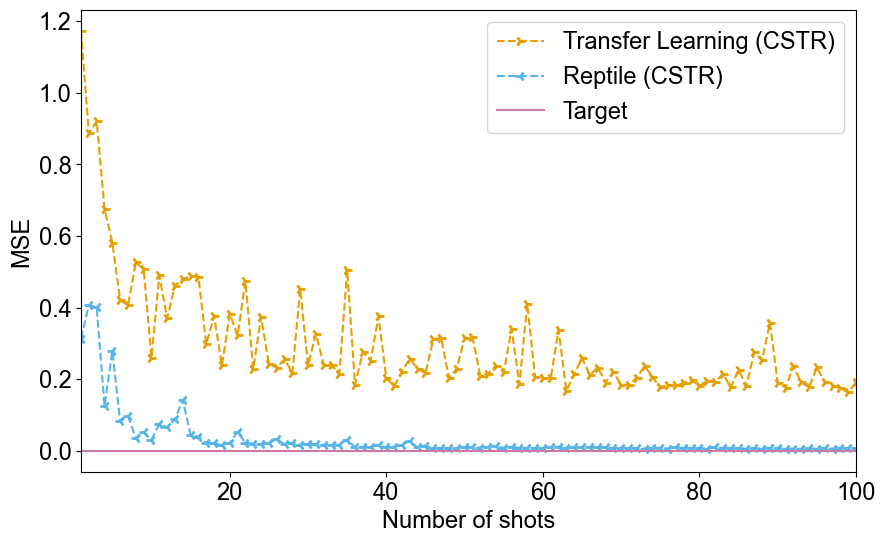

In [69]:
# load packages
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

# modify global setting
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

# Testing
test_loss_normal = [0.0001806485304716055]

size = 100
x = np.arange(1,size+1,1)

# color code: "#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"
plt.figure(figsize=(10,6))
plt.rc('font', size=17)
plt.plot(x, test_loss_transfer_cstr[:size], '--', color='#E69F00', marker='4', linewidth=1.5, markersize=7.5, markeredgewidth=2, label='Transfer Learning (CSTR)')
plt.plot(x, test_loss_reptile_cstr[:size], '--', color='#56B4E9', marker='3', linewidth=1.5, markersize=7.5, markeredgewidth=2, label='Reptile (CSTR)')
# plt.plot(x, test_loss_transfer_batch[:size], '--', color='#E69F00', marker='2', linewidth=1.5, markersize=10, markeredgewidth=2.5, label='Transfer Learning (Batch)')
# plt.plot(x, test_loss_reptile_batch[:size], '--', color='#56B4E9', marker='1', linewidth=1.5, markersize=10, markeredgewidth=2.5, label='Reptile (Batch)')
plt.plot(x, test_loss_normal*(size), color='#CC79A7', linewidth=1.5, label='Target')
plt.legend()
plt.xlabel("Number of shots")
plt.ylabel("MSE")
plt.margins(x=0)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.savefig('transfer_reptile_cstr.pdf')
plt.show()

meta NOT subset; don't know how to subset; dropped


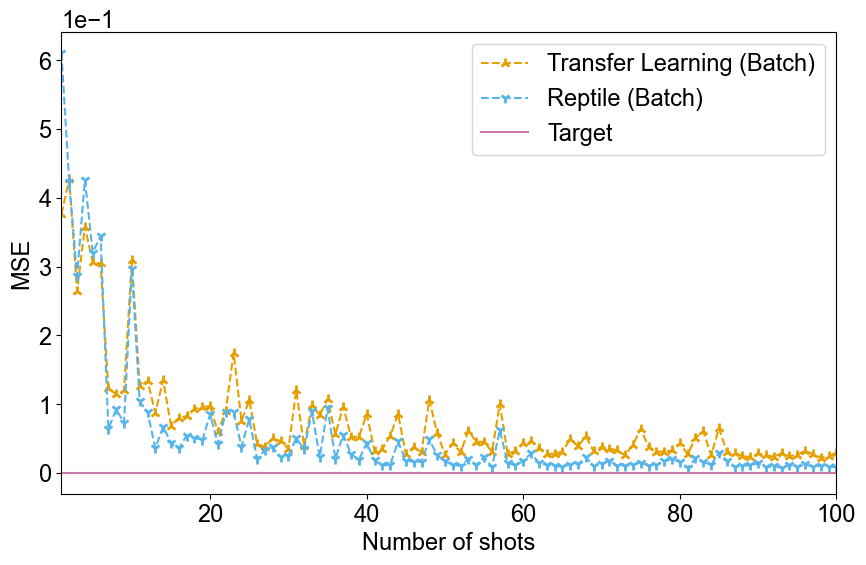

In [68]:
# load packages
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

# modify global setting
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

# Testing
test_loss_normal = [0.0001806485304716055]

size = 100
x = np.arange(1,size+1,1)

# color code: "#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"
plt.figure(figsize=(10,6))
plt.rc('font', size=17)
plt.plot(x, test_loss_transfer_batch[:size], '--', color='#E69F00', marker='2', linewidth=1.5, markersize=7.5, markeredgewidth=2, label='Transfer Learning (Batch)')
plt.plot(x, test_loss_reptile_batch[:size], '--', color='#56B4E9', marker='1', linewidth=1.5, markersize=7.5, markeredgewidth=2, label='Reptile (Batch)')
plt.plot(x, test_loss_normal*(size), color='#CC79A7', linewidth=1.5, label='Target')
plt.legend()
plt.xlabel("Number of shots")
plt.ylabel("MSE")
plt.margins(x=0)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.savefig('transfer_reptile_batch.pdf')
plt.show()

In [66]:
for i in range(100):
    if (i+1) % 5 == 0:
        print("Test loss of transfer learning using %d-shots for CSTR: %f" % (i+1, test_loss_transfer_cstr[i]))
        print("Test loss of reptile using %d-shots for CSTR: %f" % (i+1, test_loss_reptile_cstr[i]))

Test loss of transfer learning using 5-shots for CSTR: 0.581207
Test loss of reptile using 5-shots for CSTR: 0.278183
Test loss of transfer learning using 10-shots for CSTR: 0.260239
Test loss of reptile using 10-shots for CSTR: 0.030405
Test loss of transfer learning using 15-shots for CSTR: 0.488192
Test loss of reptile using 15-shots for CSTR: 0.044228
Test loss of transfer learning using 20-shots for CSTR: 0.382190
Test loss of reptile using 20-shots for CSTR: 0.022086
Test loss of transfer learning using 25-shots for CSTR: 0.242627
Test loss of reptile using 25-shots for CSTR: 0.022291
Test loss of transfer learning using 30-shots for CSTR: 0.238505
Test loss of reptile using 30-shots for CSTR: 0.019197
Test loss of transfer learning using 35-shots for CSTR: 0.505295
Test loss of reptile using 35-shots for CSTR: 0.031327
Test loss of transfer learning using 40-shots for CSTR: 0.202489
Test loss of reptile using 40-shots for CSTR: 0.010153
Test loss of transfer learning using 45-sh

In [67]:
for i in range(100):
    if (i+1) % 5 == 0:
        print("Test loss of transfer learning using %d-shots for Batch: %f" % (i+1, test_loss_transfer_batch[i]))
        print("Test loss of reptile using %d-shots for Batch: %f" % (i+1, test_loss_reptile_batch[i]))

Test loss of transfer learning using 5-shots for Batch: 0.305956
Test loss of reptile using 5-shots for Batch: 0.320357
Test loss of transfer learning using 10-shots for Batch: 0.309833
Test loss of reptile using 10-shots for Batch: 0.296210
Test loss of transfer learning using 15-shots for Batch: 0.068664
Test loss of reptile using 15-shots for Batch: 0.043306
Test loss of transfer learning using 20-shots for Batch: 0.097260
Test loss of reptile using 20-shots for Batch: 0.085356
Test loss of transfer learning using 25-shots for Batch: 0.105881
Test loss of reptile using 25-shots for Batch: 0.078185
Test loss of transfer learning using 30-shots for Batch: 0.034818
Test loss of reptile using 30-shots for Batch: 0.025033
Test loss of transfer learning using 35-shots for Batch: 0.107368
Test loss of reptile using 35-shots for Batch: 0.093966
Test loss of transfer learning using 40-shots for Batch: 0.085732
Test loss of reptile using 40-shots for Batch: 0.043442
Test loss of transfer lear

meta NOT subset; don't know how to subset; dropped


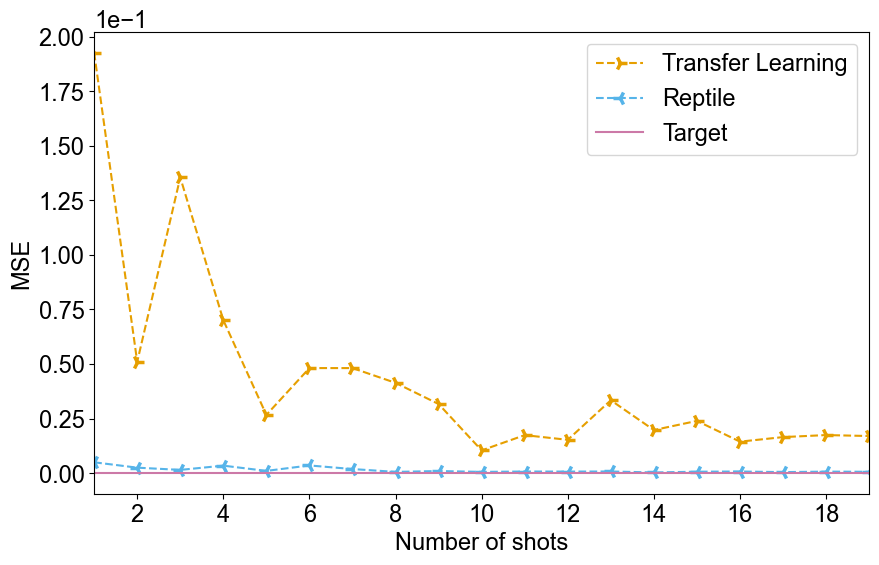

In [ ]:
# load packages
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

# modify global setting
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

# Testing
test_loss_normal = [0.0001806485304716055]

test_loss_transfer = [0.0760587, 0.19264211, 0.05098918, 0.13549507, 0.07008416, 0.02668532,
 0.04813274, 0.04812812, 0.04135853, 0.03165978, 0.01041419, 0.01740543,
 0.01525537, 0.03338615, 0.01973099, 0.02392973, 0.01442106, 0.01650328,
 0.01743652, 0.01699655, 0.01404323, 0.02605721, 0.02215327, 0.00887599,
 0.01351541, 0.00659345, 0.0284018, 0.00910603, 0.01155156, 0.00804818,
 0.007862, 0.01804584, 0.03178694, 0.00588786, 0.0152336, 0.01057846,
 0.00567555, 0.01552893, 0.00630804, 0.00822648, 0.00803101, 0.01176816,
 0.00838222, 0.00619461, 0.01030739, 0.0053059, 0.00478398, 0.0083082,
 0.00691932, 0.00736471, 0.01226368, 0.00576641, 0.00842309, 0.00567105,
 0.0091878, 0.0052243, 0.0051321, 0.00598129, 0.00717541, 0.00489835,
 0.00494795, 0.00552613, 0.00478396, 0.0087103, 0.01588763, 0.00532074,
 0.01016548, 0.00615263, 0.00791069, 0.00454014, 0.01288502, 0.0087574,
 0.01109827, 0.00547487, 0.00791328, 0.0056625, 0.00566475, 0.00607383,
 0.00565312, 0.00648336, 0.00584012, 0.00510806, 0.00527921, 0.00755817,
 0.00566722, 0.00494777, 0.00826801, 0.00533492, 0.00596292, 0.00463559,
 0.00424344, 0.00832772, 0.00446348, 0.00467164, 0.00532608, 0.0041623,
 0.00450347, 0.00524812, 0.00391851, 0.00494448]

test_loss_reptile = [0.00571875, 0.0049638, 0.00250131, 0.00147416, 0.00342356, 0.00101817,
 0.00351164, 0.00186342, 0.00056255, 0.00094844, 0.00056551, 0.00073595,
 0.0006999, 0.00075083, 0.00030465, 0.00064405, 0.00073975, 0.00046035,
 0.00068664, 0.00061755, 0.00053143, 0.0010788, 0.00115187, 0.00032211,
 0.00042913, 0.00034541, 0.00047102, 0.00040097, 0.00029342, 0.00030344,
 0.00033174, 0.00038588, 0.00073754, 0.00027214, 0.00052592, 0.00035562,
 0.00024035, 0.00061382, 0.00025188, 0.00033157, 0.00034293, 0.000261,
 0.00030666, 0.00025118, 0.00029268, 0.00020834, 0.00019891, 0.00031845,
 0.00028218, 0.00020072, 0.00040009, 0.00019932, 0.00021928, 0.0002118,
 0.00023176, 0.00019813, 0.00018565, 0.00024943, 0.00019583, 0.00017586,
 0.00018972, 0.00018944, 0.0001942, 0.00017568, 0.00027392, 0.00023769,
 0.00024123, 0.00019643, 0.00026549, 0.00017478, 0.00036684, 0.00029168,
 0.00032081, 0.0002115, 0.00020268, 0.00017881, 0.0001935, 0.00018632,
 0.00017137, 0.00018606, 0.00018261, 0.00019924, 0.00019881, 0.00020608,
 0.00018255, 0.00017348, 0.00024419, 0.00018577, 0.00017282, 0.00016871,
 0.0001608,  0.00017823, 0.00018282, 0.00017858, 0.00016007, 0.00017325,
 0.00018335, 0.00016467, 0.00017209, 0.00017375]

size = 20
x = np.arange(1,size,1)

# color code: "#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"
plt.figure(figsize=(10,6))
plt.rc('font', size=17)
plt.plot(x, test_loss_transfer[1:size], '--', color='#E69F00', marker='4', linewidth=1.5, markersize=10, markeredgewidth=2.5, label='Transfer Learning')
plt.plot(x, test_loss_reptile[1:size], '--', color='#56B4E9', marker='3', linewidth=1.5, markersize=10, markeredgewidth=2.5, label='Reptile')
plt.plot(x, test_loss_normal*(size-1), color='#CC79A7', linewidth=1.5, label='Target')
plt.legend()
plt.xlabel("Number of shots")
plt.ylabel("MSE")
plt.margins(x=0)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.savefig('transfer_reptile.pdf')
plt.show()